In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
stop_words = set(stopwords.words('english'))
from google.colab import drive
drive.mount('/content/drive') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Read in the wine review data:
df = pd.read_csv("./drive/My Drive/winemag-data-130k-v2.csv", index_col=0)
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [0]:
# Create a tokenized set of documents which are lists of words included in each description:
docs = list(df["description"])
# use this regex to remove punctuation
pattern = r'''(?x)  # set flag to allow verbose regexps
(?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
|\w+(?:[-']\w+)*    # words with optional internal hyphens
|\$?\d+(?:\.\d+)?   # currency, e.g. $12.80 
|\.\.\.             # elipses
|[.,;"'?()-_`]      # these are separate tokens
'''
# Iterate through the docs and tokenize them
for i in range(len(docs)):
  word_tokens = word_tokenize(" ".join(nltk.regexp_tokenize(docs[i], pattern))) 
  docs[i] = filtered_sentence = [w.lower() for w in word_tokens if not w.lower() in stop_words]

In [0]:
# Create a list of taggedDocument objects for use in the doc2vec model
documents = [TaggedDocument(doc, [str(i)]) for i, doc in enumerate(docs)]

In [0]:
# Train a doc2vec model on our descriptions:
model = Doc2Vec(documents, vector_size=10, window=10, min_count=3, workers=4)

In [0]:
# Define a function to create a document vector for each wine using our trained model:
def get_doc_vec(doc):
  return model.infer_vector(doc.split())

In [0]:
# Create index feature for use in the closest document function
df["idx"] = np.arange(len(df))
# apply the document vector function:
df["document_vector"] = df["description"].apply(get_doc_vec)

In [0]:
#df.head()
#df.to_csv("./drive/My Drive/winemag-data-130k-v2_docvecs.csv", index=False)

In [0]:
# Find the 5 most similar wines by deescription:
def closest_descriptions(idx):
  sims = model.docvecs.most_similar([idx], topn=5)
  return [sim[0] for sim in sims]

In [0]:
# Apply the closest descriptions function:
df["closest_description"] = df["idx"].apply(closest_descriptions)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
# Inspect some results:
for i in range(3):
  print(i, "\n", df["description"][i], "\n")
  for j in range(2):
    print(df["description"].iloc[int(df["closest_description"][i][j])], "\n\n")

0 
 Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. 

A beautifully fragrant Grillo, this has a flower aroma and an evident touch of zesty spice on the finish. The mouthfeel is lean and fresh. 


You'll find bright berry notes followed by white licorice, forest floor and a distant touch of chopped herbs in this fresh, well-integrated Barbera from Monferrato. The mouthfeel is not too concentrated and the wine is naturally acidic (try it with cheese- or butter-based pasta dishes). 


1 
 This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016. 

Bouncy berry and cherry aromas are more or less standard for basic Garnacha. This wine feels a bit gummy and grabby, but not sticky. Lightly herbal, minty

In [0]:
# Create red and white subsets and label which aggregated variety they belong to:
sample_df= df.sample(n=13000, random_state=42)
reds = ["Noir", "Grenache", "Merlot", "Sangiovese", "Nebbiolo", "Tempranillo", "Cabernet Sauvignon", "Malbec"]
whites = ["Riesling", "Grigio", "Blanc", "Moscato", "Gewürztraminer", "Sémillon", "Viognier", "Chardonnay"]
subsetRed = sample_df[sample_df['variety'].str.contains('|'.join(reds))]
subsetRed["variety"] = "Red"
subsetWhite = sample_df[sample_df['variety'].str.contains('|'.join(whites))] 
subsetWhite["variety"] = "White"
#subsetRose = sample_df[sample_df['variety'].str.contains("Rosé")] 
#subsetRose["variety"] = "Rosé"

# t-SNE embed the subset:
subset = pd.concat([subsetRed, subsetWhite]) #,subsetRose])
data_embed=TSNE(n_components=2, perplexity=50, verbose=2, n_iter=500, method='barnes_hut').fit_transform(np.stack(subset["document_vector"].to_numpy()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6644 samples in 0.004s...
[t-SNE] Computed neighbors for 6644 samples in 0.792s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6644
[t-SNE] Computed conditional probabilities for sample 2000 / 6644
[t-SNE] Computed conditional probabilities for sample 3000 / 6644
[t-SNE] Computed conditional probabilities for sample 4000 / 6644
[t-SNE] Computed conditional probabilities for sample 5000 / 6644
[t-SNE] Computed conditional probabilities for sample 6000 / 6644
[t-SNE] Computed conditional probabilities for sample 6644 / 6644
[t-SNE] Mean sigma: 0.051823
[t-SNE] Computed conditional probabilities in 0.750s
[t-SNE] Iteration 50: error = 85.4196396, gradient norm = 0.0127547 (50 iterations in 3.661s)
[t-SNE] Iteration 100: error = 78.3039551, gradient norm = 0.0002928 (50 iterations in 2.694s)
[t-SNE] Iteration 150: error = 78.2436523, gradient norm = 0.0000169 (50 iterations in 2.310s)
[t-SNE] Iteration 200: error =

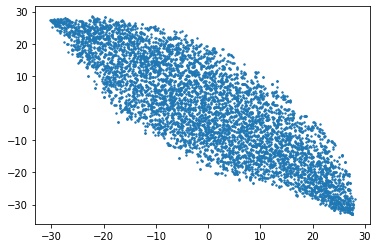

In [0]:
## Vizualise
%matplotlib inline
from matplotlib import pyplot as plt

x_axis= data_embed[:,0]
y_axis= data_embed[:,1]

plt.scatter(x_axis, y_axis, s=2)
plt.show()

In [0]:
# Create a tsv file for our embeded representation of our model:
d = {'x': data_embed[:,0], 'y': data_embed[:,1], 'variety' : subset["variety"], "points" : subset["points"], "taster" : subset["taster_name"]}
df_embed = pd.DataFrame(data=d)
df_embed.head() 
df_embed.to_csv('model2.tsv', sep='\t', index=False)

In [0]:
#sample_df["variety"].unique()
# df["taster_name"].unique()

In [0]:
# Create subsets with just two varieties:
sample_df= df.sample(n=13000, random_state=42)
merls = ["Merlot"]
ries = ["Riesling"]
subsetmerls = sample_df[sample_df['variety'].str.contains('|'.join(merls))]
subsetmerls["variety"] = "Merlot"
subsetries = sample_df[sample_df['variety'].str.contains('|'.join(ries))] 
subsetries["variety"] = "Riesling"
#subsetRose = sample_df[sample_df['variety'].str.contains("Rosé")] 
#subsetRose["variety"] = "Rosé"
subset = pd.concat([subsetmerls, subsetries])#, subsetRose])
data_embed=TSNE(n_components=2, perplexity=50, verbose=2, method='barnes_hut').fit_transform(np.stack(subset["document_vector"].to_numpy()))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 876 samples in 0.001s...
[t-SNE] Computed neighbors for 876 samples in 0.037s...
[t-SNE] Computed conditional probabilities for sample 876 / 876
[t-SNE] Mean sigma: 0.072818
[t-SNE] Computed conditional probabilities in 0.094s
[t-SNE] Iteration 50: error = 60.7290001, gradient norm = 0.3244623 (50 iterations in 0.417s)
[t-SNE] Iteration 100: error = 60.1383591, gradient norm = 0.3300854 (50 iterations in 0.429s)
[t-SNE] Iteration 150: error = 60.4958916, gradient norm = 0.3117556 (50 iterations in 0.405s)
[t-SNE] Iteration 200: error = 61.2467461, gradient norm = 0.3163965 (50 iterations in 0.387s)
[t-SNE] Iteration 250: error = 60.2348518, gradient norm = 0.3202519 (50 iterations in 0.435s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.234852
[t-SNE] Iteration 300: error = 1.1302289, gradient norm = 0.0011643 (50 iterations in 0.335s)
[t-SNE] Iteration 350: error = 1.0902035, gradient norm = 0.0002916 

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

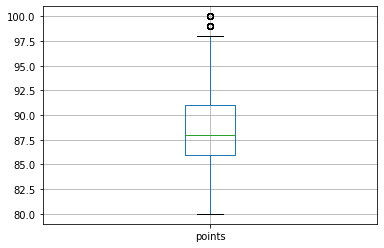

In [0]:
boxplot = df.boxplot(column=['points'])

In [0]:
df['points/price'] = (df["points"] / df["price"])

In [0]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery,idx,document_vector,closest_description,points/price
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,0,"[-0.031218965, -0.099459924, 0.010340899, 0.02...","[127679, 98981, 26901, 43448, 35250]",NaN
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,1,"[0.018105369, -0.15248235, 0.049270216, 0.2182...","[60658, 8648, 129235, 96895, 120482]",5.800000
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2,"[0.038880985, -0.13466986, -0.00963622, 0.1377...","[78546, 5169, 104867, 43029, 27643]",6.214286
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,3,"[0.099366255, -0.2311258, 0.075494245, 0.16117...","[125606, 43082, 124168, 69935, 28219]",6.692308
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,4,"[0.08297854, -0.25608635, 0.07158137, 0.157123...","[96662, 71491, 120607, 75631, 33731]",1.338462


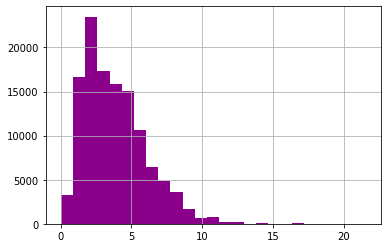

In [0]:
hist = df["points/price"].hist(bins=25, color="darkmagenta")

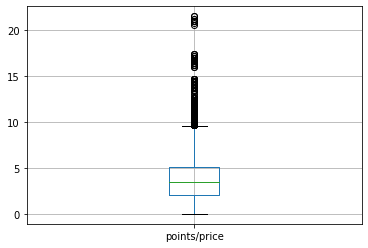

In [0]:
boxplot = df.boxplot(column=['points/price'])

In [0]:
df_price_exists = df.dropna(subset=['price'])
X = df_price_exists["price"]
y = df_price_exists["points"]

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
regr = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=100)
regr.fit(X_train.to_numpy().reshape(-1, 1), np.stack(y_train.to_numpy()))  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
y_pred = regr.predict(X_valid.to_numpy().reshape(-1, 1))
mean_absolute_error(y_pred, np.stack(y_valid.astype(float).to_numpy()))

1.9201507133534814

In [0]:
X2 = df["document_vector"]
y2 = df["points"]

In [0]:
X2_train, X2_valid, y2_train, y2_valid = train_test_split(X2, y2, test_size=0.2, random_state=42)

In [0]:
regr = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=100)
regr.fit(np.stack(X2_train.to_numpy()), np.stack(y2_train.to_numpy()))  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
y2_pred = regr.predict(np.stack(X2_valid.to_numpy()))
mean_absolute_error(y2_pred, np.stack(y2_valid.astype(float).to_numpy()))

2.3765622707863803

In [0]:
dvec = df_price_exists["document_vector"].tolist()

In [0]:
X3 = []
for i in range(len(dvec)):
  X3.append(np.hstack((dvec[i], [df_price_exists["price"].iloc[i]])))

In [0]:
X3 = np.array(X3)

In [0]:
X3_train, X3_valid, y3_train, y3_valid = train_test_split(X3, y, test_size=0.2, random_state=42)

In [0]:
regr = RandomForestRegressor(max_depth=3, random_state=42, n_estimators=100)
regr.fit(X3_train, np.stack(y_train.to_numpy()))  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
y3_pred = regr.predict(np.stack(X3_valid))
mean_absolute_error(y3_pred, np.stack(y3_valid.astype(float).to_numpy()))

1.9155034962787498

In [0]:
df["points"].describe()

count    129971.000000
mean         88.447138
std           3.039730
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64